In [0]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col, lit, count, isnan, when
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

# Read Data

In [0]:
comments_final = spark.read.parquet("/Dataset/comments_final")
submissions_final = spark.read.parquet("/Dataset/submissions_final")

In [0]:
## Extract subreddits from submissions
datingapp_df_submission = submissions_final.filter((col("subreddit")=='Bumble') | (col("subreddit")=='Tinder')|(col("subreddit")=='hingeapp')|(col("subreddit")=='dating')| (col("subreddit")=='DatingApps')).cache()

relationship_df_submission = submissions_final.filter((col("subreddit")=='relationships') | (col("subreddit")=='AskMen') | (col("subreddit")=='AskWomen')).cache()

advice_df_submission = submissions_final.filter((col("subreddit")=='relationship_advice') | (col("subreddit")=='datingoverforty')|(col("subreddit")=='datingoverthirty')| (col("subreddit")=='datingadvice')| (col("subreddit")=='datingoverforty')| (col("subreddit")=='datingoverfifty')).cache()

## Extract subreddits from comments
datingapp_df_comments = comments_final.filter((col("comment_subreddit")=='Bumble') | (col("comment_subreddit")=='Tinder')|(col("comment_subreddit")=='hingeapp')|(col("comment_subreddit")=='dating')| (col("comment_subreddit")=='DatingApps')).cache()

relationship_df_comments = comments_final.filter((col("comment_subreddit")=='relationships') | (col("comment_subreddit")=='AskMen') | (col("comment_subreddit")=='AskWomen')).cache()

advice_df_comments = comments_final.filter((col("comment_subreddit")=='relationship_advice') | (col("comment_subreddit")=='datingoverforty')|(col("comment_subreddit")=='datingoverthirty')| (col("comment_subreddit")=='datingadvice')| (col("comment_subreddit")=='datingoverforty')| (col("comment_subreddit")=='datingoverfifty')).cache()

In [0]:
comments_final.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- comment_created_utc: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- comment_id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- comment_score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- comment_subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



In [0]:
submissions_final.printSchema()

root
 |-- id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- author: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- selftext: string (nullable = true)
 |-- title: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- score: long (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- edited: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- locked: boolean (nullable = true)



# Preparing data

Comments:  
y: can_gild  
x: Day of the week, hour, topic, sentiment, comment_score, controversiality, stickied, text_length  
  
  
Submission:   
y: over_18  
x: Day of the week, hour, topic, sentiment, num_comments, score, stickied，text_length

In [0]:
#Check the distribution of selected variables.
import pyspark.sql.functions as f

submissions_final.groupBy('over_18').agg(f.count('score').alias('count')).show()

+-------+---------+
|over_18|    count|
+-------+---------+
|   true|222851056|
|  false|411071883|
+-------+---------+



In [0]:
submissions_final.groupBy('stickied').agg(f.count('score').alias('count')).show()

+--------+---------+
|stickied|    count|
+--------+---------+
|    true|  1677981|
|   false|632244958|
+--------+---------+



In [0]:
comments_final.groupBy('stickied').agg(f.count('comment_score').alias('count')).show()

+--------+----------+
|stickied|     count|
+--------+----------+
|    true|  73679309|
|   false|4399877453|
+--------+----------+



In [0]:
comments_final.groupBy('gilded').agg(f.count('comment_score').alias('count'),
         f.mean('comment_score').alias('mean'),
         f.stddev('comment_score').alias('std'),
         f.min('comment_score').alias('min'),
         f.expr('percentile(comment_score, array(0.25))')[0].alias('%25'),
         f.expr('percentile(comment_score, array(0.5))')[0].alias('%50'),
         f.expr('percentile(comment_score, array(0.75))')[0].alias('%75'),
         f.max('comment_score').alias('max')).show()

+------+----------+------------------+------------------+------+-----+----+-----+-----+
|gilded|     count|              mean|               std|   min|  %25| %50|  %75|  max|
+------+----------+------------------+------------------+------+-----+----+-----+-----+
|     0|4472528498| 7.194533542578671| 81.44765043794823|-13736|  1.0| 1.0|  3.0|75053|
|    29|        46|14.565217391304348| 54.74248895162109|   -63|  2.0| 5.0|13.75|  366|
|    26|        72|  8.98611111111111|17.771232534360056|   -17|  1.0| 5.5|13.25|  124|
|    19|       213| 140.8967136150235| 1217.483578068512|   -14|  1.0| 5.0| 11.0|15047|
|    65|         4|              12.0|22.818121453499774|    -3| 0.75| 2.5|13.75|   46|
|    54|         6|               8.0|11.832159566199232|    -5|  1.5| 5.5| 11.0|   29|
|    22|       110| 451.3363636363636|  3653.79462742496|   -28|  1.0| 4.0| 10.0|36448|
|     7|      3838| 528.7027097446587|3523.5729881045213| -2051|  1.0| 2.0|  5.0|69867|
|    31|        49| 477.24489795

In [0]:
comments_final.groupBy('can_gild').agg(f.count('comment_score').alias('count')).show()

+--------+----------+
|can_gild|     count|
+--------+----------+
|    true|4262352636|
|   false| 211204126|
+--------+----------+



In [0]:
import pyspark.sql.functions as f
## Add topic
# label : dating_app, relationship, advice
datingapp_df_submission = datingapp_df_submission.withColumn("submission_topic", f.lit('datingapp'))
#datingapp_df_submission.show()
relationship_df_submission = relationship_df_submission.withColumn("submission_topic", f.lit('relationship'))
#relationship_df_submission.show()
advice_df_submission = advice_df_submission.withColumn("submission_topic", f.lit('advice'))
#advice_df_submission.show()

datingapp_df_comments = datingapp_df_comments.withColumn("comments_topic", f.lit('datingapp'))
#datingapp_df_comments.show()
relationship_df_comments = relationship_df_comments.withColumn("comments_topic", f.lit('relationship'))
#relationship_df_comments.show()
advice_df_comments = advice_df_comments.withColumn("comments_topic", f.lit('advice'))
#advice_df_comments.show()


In [0]:
submission_union = datingapp_df_submission.unionAll(relationship_df_submission).unionAll(advice_df_submission)
comments_union = datingapp_df_comments.unionAll(relationship_df_comments).unionAll(advice_df_comments)

In [0]:
## text length
import pyspark.sql.functions as f

#comments_union=comments_union.filter((comments_union.body != '[deleted]' )& (comments_union.body != '[removed]'))
#submission_union = submission_union.filter((submission_union.selftext != '[deleted]' )& (submission_union.selftext != '[removed]'))

comments_union=comments_union.withColumn("length", f.length(col("body")))

submission_union=submission_union.withColumn("length", f.length(col("title")))


In [0]:
submission_union.show()
comments_union.show()

+------+--------------------+--------------------+-----------+---------+------------+--------------------+--------------------+------------+-----+-------+-------+-------------+-----------+--------+------+----------------+------+
|    id|           permalink|              author|created_utc|subreddit|subreddit_id|            selftext|               title|num_comments|score|is_self|over_18|       edited|     domain|stickied|locked|submission_topic|length|
+------+--------------------+--------------------+-----------+---------+------------+--------------------+--------------------+------------+-----+-------+-------+-------------+-----------+--------+------+----------------+------+
|lqcyqs|/r/dating/comment...|           [deleted]| 1614067362|   dating|    t5_2qhb1|           [deleted]|Too fat for onlin...|          15|    1|   true|  false|        false|self.dating|   false| false|       datingapp|    32|
|lqcyrt|/r/dating/comment...|  AnteaterFlashy6499| 1614067365|   dating|    t5_2qhb1

In [0]:
## Add Sentiment
documentAssembler = DocumentAssembler()\
    .setInputCol("body")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = SentimentDLModel.pretrained(name='sentimentdl_use_imdb', lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_imdb download started this may take some time.
Approximate size to download 12 MB
[OK!]


In [0]:
comments_union_ml = nlpPipeline.fit(comments_union).transform(comments_union)
comments_union_ml.cache

Out[15]: <bound method DataFrame.cache of DataFrame[author: string, body: string, can_gild: boolean, controversiality: bigint, comment_created_utc: bigint, edited: string, gilded: bigint, comment_id: string, link_id: string, parent_id: string, comment_score: bigint, stickied: boolean, comment_subreddit: string, subreddit_id: string, comments_topic: string, length: int, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence_embeddings: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentiment: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>]>

In [0]:
comments_union_ml = comments_union_ml.withColumn('sentiment', col('sentiment.result')[0]).drop('sentence_embeddings').drop('document')
comments_union_ml.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- comment_created_utc: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- comment_id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- comment_score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- comment_subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- comments_topic: string (nullable = false)
 |-- length: integer (nullable = true)
 |-- sentiment: string (nullable = true)



In [0]:
comments_union_ml.show()

+--------------------+--------------------+--------+----------------+-------------------+------+------+----------+---------+----------+-------------+--------+-----------------+------------+--------------+------+---------+
|              author|                body|can_gild|controversiality|comment_created_utc|edited|gilded|comment_id|  link_id| parent_id|comment_score|stickied|comment_subreddit|subreddit_id|comments_topic|length|sentiment|
+--------------------+--------------------+--------+----------------+-------------------+------+------+----------+---------+----------+-------------+--------+-----------------+------------+--------------+------+---------+
|Illustrious_Farm7570|I’ll be honest wi...|    true|               1|         1649701685| false|     0|   i4bre7u|t3_u19xv8| t3_u19xv8|            0|   false|           Bumble|    t5_3531l|     datingapp|   416|      neg|
|                exxR|Imagine being thi...|    true|               0|         1649701698| false|     0|   i4brfg

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("title")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = SentimentDLModel.pretrained(name='sentimentdl_use_imdb', lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline1 = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_imdb download started this may take some time.
Approximate size to download 12 MB
[OK!]


In [0]:
submission_union_ml = nlpPipeline1.fit(submission_union).transform(submission_union)
submission_union_ml.cache

Out[18]: <bound method DataFrame.cache of DataFrame[id: string, permalink: string, author: string, created_utc: bigint, subreddit: string, subreddit_id: string, selftext: string, title: string, num_comments: bigint, score: bigint, is_self: boolean, over_18: boolean, edited: string, domain: string, stickied: boolean, locked: boolean, submission_topic: string, length: int, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence_embeddings: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentiment: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>]>

In [0]:
submission_union_ml = submission_union_ml.withColumn('sentiment', col('sentiment.result')[0]).drop('sentence_embeddings').drop('document')
submission_union_ml.printSchema()

root
 |-- id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- author: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- selftext: string (nullable = true)
 |-- title: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- score: long (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- edited: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- locked: boolean (nullable = true)
 |-- submission_topic: string (nullable = false)
 |-- length: integer (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- Day_of_week: integer (nullable = true)
 |-- Hour: integer (nullable = true)



In [0]:
submission_union_ml.groupBy('sentiment').agg(f.count('score').alias('count')).show()

+---------+-------+
|sentiment|  count|
+---------+-------+
|      pos| 736337|
|      neg|1949066|
|  neutral|  17981|
+---------+-------+



In [0]:
##Add timestamp
from pyspark.sql.functions import *
# Step 1: transform to the correct col format
comments_union_ml = comments_union_ml.withColumn("timestamp", from_unixtime("comment_created_utc", "yyyy-MM-dd HH:mm:ss"))

# Step 2 & 3: Extract the needed information
comments_union_ml = comments_union_ml.withColumn('Day_of_week', dayofweek(comments_union_ml.timestamp))
comments_union_ml = comments_union_ml.withColumn('Hour', hour(comments_union_ml.timestamp))

In [0]:
# Step 1: transform to the correct col format
submission_union_ml = submission_union_ml.withColumn("timestamp", from_unixtime("created_utc", "yyyy-MM-dd HH:mm:ss"))

# Step 2 & 3: Extract the needed information
submission_union_ml = submission_union_ml.withColumn('Day_of_week', dayofweek(submission_union_ml.timestamp))
submission_union_ml = submission_union_ml.withColumn('Hour', hour(submission_union_ml.timestamp))

In [0]:
comments_union_ml.show()

+--------------------+--------------------+--------+----------------+-------------------+------+------+----------+---------+----------+-------------+--------+-----------------+------------+--------------+------+---------+-------------------+-----------+----+
|              author|                body|can_gild|controversiality|comment_created_utc|edited|gilded|comment_id|  link_id| parent_id|comment_score|stickied|comment_subreddit|subreddit_id|comments_topic|length|sentiment|          timestamp|Day_of_week|Hour|
+--------------------+--------------------+--------+----------------+-------------------+------+------+----------+---------+----------+-------------+--------+-----------------+------------+--------------+------+---------+-------------------+-----------+----+
|Illustrious_Farm7570|I’ll be honest wi...|    true|               1|         1649701685| false|     0|   i4bre7u|t3_u19xv8| t3_u19xv8|            0|   false|           Bumble|    t5_3531l|     datingapp|   416|      neg|20

In [0]:
submission_union_ml.show()

+------+--------------------+--------------------+-----------+---------+------------+--------------------+--------------------+------------+-----+-------+-------+-------------+-----------+--------+------+----------------+------+---------+----------+-----------+----+
|    id|           permalink|              author|created_utc|subreddit|subreddit_id|            selftext|               title|num_comments|score|is_self|over_18|       edited|     domain|stickied|locked|submission_topic|length|sentiment| timestamp|Day_of_week|Hour|
+------+--------------------+--------------------+-----------+---------+------------+--------------------+--------------------+------------+-----+-------+-------+-------------+-----------+--------+------+----------------+------+---------+----------+-----------+----+
|lqcyqs|/r/dating/comment...|           [deleted]| 1614067362|   dating|    t5_2qhb1|           [deleted]|Too fat for onlin...|          15|    1|   true|  false|        false|self.dating|   false| f

In [0]:
submission_union_ml.groupby("Day_of_week").count().show()

+-----------+------+
|Day_of_week| count|
+-----------+------+
|          1|390589|
|          6|369957|
|          3|404283|
|          5|379749|
|          4|390455|
|          2|412652|
|          7|355699|
+-----------+------+



In [0]:
submission_union_ml.groupby("Hour").count().show()

+----+------+
|Hour| count|
+----+------+
|  12| 85978|
|  22|134846|
|  13| 99334|
|   6| 94377|
|   3|121706|
|   1|125325|
|  16|132935|
|  20|137255|
|  19|138443|
|  15|126811|
|  17|136104|
|  21|137157|
|  11| 75628|
|  14|113731|
|   0|127003|
|  18|137277|
|   5|105471|
|   4|115340|
|   2|125575|
|   9| 72010|
+----+------+
only showing top 20 rows



In [0]:
comments_union_ml.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- comment_created_utc: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- comment_id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- comment_score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- comment_subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- comments_topic: string (nullable = false)
 |-- length: integer (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- Day_of_week: integer (nullable = true)
 |-- Hour: integer (nullable = true)



In [0]:
##Select Columns

comments_ML = comments_union_ml.select(col("can_gild"),col("Day_of_week"),col("Hour"),col("comments_topic"),col("sentiment"),col("comment_score"),col("controversiality"),col("stickied"),col("length"))
comments_ML.printSchema()

submission_ML = submission_union_ml.select(col("over_18"),col("Day_of_week"),col("Hour"),col("submission_topic"),col("sentiment"),col("num_comments"),col("score"),col("stickied"),col("length"))
submission_ML.printSchema()

root
 |-- can_gild: boolean (nullable = true)
 |-- Day_of_week: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- comments_topic: string (nullable = false)
 |-- sentiment: string (nullable = true)
 |-- comment_score: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- length: integer (nullable = true)

root
 |-- over_18: boolean (nullable = true)
 |-- Day_of_week: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- submission_topic: string (nullable = false)
 |-- sentiment: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- length: integer (nullable = true)



In [0]:
comments_ML.printSchema()

root
 |-- can_gild: boolean (nullable = true)
 |-- Day_of_week: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- comments_topic: string (nullable = false)
 |-- sentiment: string (nullable = true)
 |-- comment_score: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- length: integer (nullable = true)



In [0]:
submission_ML.printSchema()

root
 |-- over_18: boolean (nullable = true)
 |-- Day_of_week: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- submission_topic: string (nullable = false)
 |-- sentiment: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- length: integer (nullable = true)



In [0]:
print("Comments_ML Dataframe has ", comments_ML.count(), "Rows",  len(comments_ML.columns), "Columns")
print("submission_ML Dataframe has ", submission_ML.count(), "Rows",  len(submission_ML.columns), "Columns")

Comments_ML Dataframe has  44242410 Rows 9 Columns
submission_ML Dataframe has  2703384 Rows 9 Columns


In [0]:
for col in submission_ML.columns:
    print(col, "with null values: ", submission_ML.filter(submission_ML[col].isNull()).count())

over_18 with null values:  0
Day_of_week with null values:  0
Hour with null values:  0
submission_topic with null values:  0
sentiment with null values:  0
num_comments with null values:  0
score with null values:  0
stickied with null values:  0
length with null values:  0


In [0]:
from pyspark.sql.types import IntegerType
comments_ML=comments_ML.withColumn("stickied",col("stickied").cast(IntegerType()))
comments_ML=comments_ML.withColumn("can_gild",col("can_gild").cast(IntegerType()))
submission_ML=submission_ML.withColumn("stickied",col("stickied").cast(IntegerType()))
submission_ML=submission_ML.withColumn("over_18",col("over_18").cast(IntegerType()))


In [0]:
comments_ML.printSchema()

root
 |-- can_gild: integer (nullable = true)
 |-- Day_of_week: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- comments_topic: string (nullable = false)
 |-- sentiment: string (nullable = true)
 |-- comment_score: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- stickied: integer (nullable = true)
 |-- length: integer (nullable = true)



In [0]:
submission_ML.printSchema()

root
 |-- over_18: integer (nullable = true)
 |-- Day_of_week: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- submission_topic: string (nullable = false)
 |-- sentiment: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: integer (nullable = true)
 |-- length: integer (nullable = true)



In [0]:
comments_ML_small = comments_ML.sample(True, 0.0001, 1234)
comments_padf = comments_ML_small.toPandas()
comments_padf.to_csv('comments.csv')


# Analyze Comments Data

### Split data into train, test, and split

In [0]:
# create small dataset
from random import sample
comments_small = comments_ML.sample(True, 0.0001, 1234)

In [0]:
#train_data, test_data, predict_data = comments_ML.randomSplit([0.8, 0.18, 0.02], 24)
train_data, test_data, predict_data = comments_small.randomSplit([0.8, 0.18, 0.02], 24)

In [0]:
train_data.show()

+--------+-----------+----+--------------+---------+-------------+----------------+--------+------+
|can_gild|Day_of_week|Hour|comments_topic|sentiment|comment_score|controversiality|stickied|length|
+--------+-----------+----+--------------+---------+-------------+----------------+--------+------+
|       1|          6|  22|     datingapp|      pos|            1|               0|       0|    33|
|       1|          6|   9|     datingapp|      neg|            1|               0|       0|    80|
|       1|          7|   2|     datingapp|      pos|          410|               0|       0|    29|
|       1|          4|  18|     datingapp|      neg|            1|               0|       0|   337|
|       1|          3|   2|     datingapp|      pos|            1|               0|       0|    25|
|       1|          1|  16|     datingapp|      neg|            1|               0|       1|   802|
|       1|          5|  11|     datingapp|      pos|            6|               0|       0|    38|


In [0]:
#print("Number of training records: " + str(train_data.count()))
#print("Number of testing records : " + str(test_data.count()))
#print("Number of prediction records : " + str(predict_data.count()))

### Create pipeline and train random forest models to classify whether the comments are gild.

In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [0]:
# Convert all the string fields to numeric indices by StringIndexer estimator.
stringIndexer_topic = StringIndexer(inputCol="comments_topic", outputCol="topic_ix", handleInvalid="keep")
stringIndexer_sentiment = StringIndexer(inputCol="sentiment", outputCol="sentiment_ix", handleInvalid="keep")


In [0]:
# Convert the index variables that have more than two levels by the function OneHotEncoder.
onehot_topic = OneHotEncoder(inputCol="topic_ix", outputCol="topic_vec")
onehot_sentiment = OneHotEncoder(inputCol="sentiment_ix", outputCol="sentiment_vec")
onehot_day_of_week = OneHotEncoder(inputCol="Day_of_week", outputCol="day_of_week_vec")
onehot_hour = OneHotEncoder(inputCol="Hour", outputCol="hour_vec")

In [0]:
# Create a feature vector by combining all features together using the vectorAssembler method

vectorAssembler_features = VectorAssembler(inputCols=["Day_of_week","Hour","topic_vec","sentiment_vec","comment_score","controversiality","stickied","length"], 
#    outputCol= "features")
#     inputCols=["topic_vec","sentiment_vec","comment_score","controversiality","stickied","length_vec"], 
#     outputCol= "features")
    inputCols=["topic_vec","sentiment_vec","comment_score","controversiality","stickied","length","hour_vec","day_of_week_vec"], 
    outputCol= "features")

In [0]:
#Build the random forest model for "author_premium" for classification using the RandomForestClassifier estimator. We build two models with numTrees = 200 and 300 respectively.

rf1 = RandomForestClassifier(labelCol="gild_label", featuresCol="features", numTrees=200, maxDepth=8)

In [0]:
# Build the pipeline that consists of transformers and an estimator.
pipeline_rf = Pipeline(stages=[stringIndexer_topic, 
                               stringIndexer_sentiment,
                               #label_stringIdx,
                               onehot_topic,
                               onehot_sentiment,
                               onehot_length,
                               vectorAssembler_features, 
                               rf1])

In [0]:
model_rf = pipeline_rf.fit(train_data)

In [0]:
model_rf.save("/FileStore/my_folder/fitted_models/rf_comments")

In [0]:
rf2 = RandomForestClassifier(labelCol="can_gild", featuresCol="features", numTrees=300, maxDepth=8)

In [0]:
pipeline_rf2 = Pipeline(stages=[stringIndexer_topic, 
                               stringIndexer_sentiment,
                               #label_stringIdx,
                               onehot_topic,
                               onehot_sentiment,
                               onehot_length,
                               vectorAssembler_features, 
                               rf2])

In [0]:
model_rf2 = pipeline_rf2.fit(train_data)

In [0]:
model_rf2.save("/FileStore/my_folder/fitted_models/rf2_comments")

### Model Test Results for random forest

In [0]:
model_rf = RandomForestClassificationModel.load('/FileStore/my_folder/fitted_models/rf_comments')

In [0]:
predictions = model_rf.transform(test_data)
evaluatorRF = MulticlassClassificationEvaluator(labelCol="can_gild", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

In [0]:
evaluatorRF = BinaryClassificationEvaluator(labelCol="can_gild", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result = evaluatorRF.evaluate(predictions)
print("ROC Value: ", roc_result)

In [0]:
model_rf2 = RandomForestClassificationModel.load('/FileStore/my_folder/fitted_models/rf2_comments')

In [0]:
predictions2 = model_rf2.transform(test_data)
evaluatorRF2 = MulticlassClassificationEvaluator(labelCol="can_gild", predictionCol="prediction", metricName="accuracy")
accuracy2 = evaluatorRF2.evaluate(predictions2)
print("Accuracy = %g" % accuracy2)
print("Test Error = %g" % (1.0 - accuracy2))

In [0]:
evaluatorRF2 = BinaryClassificationEvaluator(labelCol="can_gild", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result2 = evaluatorRF2.evaluate(predictions2)
print("ROC Value: ", roc_result2)

### Create pipeline and train a decision tree and an SVM model to classify if the comment is gilded

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier

dt1 = DecisionTreeClassifier(labelCol="can_gild", featuresCol="features", max_depth=5)

pipeline_rf3 = Pipeline(stages=[stringIndexer_topic, 
                               stringIndexer_sentiment, 
                               onehot_topic,
                               onehot_sentiment,
                               onehot_day_of_week,
                               onehot_hour,
                               vectorAssembler_features, 
                               dt1])

model_rf3 = pipeline_rf3.fit(train_data)

In [0]:
model_rf3.save("/FileStore/my_folder/fitted_models/dt_comments")

In [0]:
dt2 = DecisionTreeClassifier(labelCol="can_gild", featuresCol="features", max_depth=8)

pipeline_rf3_ = Pipeline(stages=[stringIndexer_topic, 
                               stringIndexer_sentiment, 
                               onehot_topic,
                               onehot_sentiment,
                               onehot_day_of_week,
                               onehot_hour,
                               vectorAssembler_features, 
                               dt2])

model_rf3_ = pipeline_rf3_.fit(train_data)

In [0]:
from pyspark.ml.classification import LinearSVC
lsvc1 = LinearSVC(labelCol="can_gild", featuresCol="features", maxIter=5, regParam=0.1)

pipeline_rf4 = Pipeline(stages=[stringIndexer_topic, 
                               stringIndexer_sentiment,
                               onehot_topic,
                               onehot_sentiment,
                               onehot_day_of_week,
                               onehot_hour,
                               vectorAssembler_features, 
                               lsvc1])

model_rf4 = pipeline_rf4.fit(train_data)

In [0]:
model_rf4.save("/FileStore/my_folder/fitted_models/svm_comments")

In [0]:
lsvc2 = LinearSVC(labelCol="can_gild", featuresCol="features", maxIter=5, regParam=0.01)

pipeline_rf4_ = Pipeline(stages=[stringIndexer_topic, 
                               stringIndexer_sentiment,
                               onehot_topic,
                               onehot_sentiment,
                               onehot_day_of_week,
                               onehot_hour,
                               vectorAssembler_features, 
                               lsvc2])

model_rf4_ = pipeline_rf4_.fit(train_data)

### Model Test Results for Decision Tree and SVM

In [0]:
model_rf3 = DecisionTreeClassificationModel.load('/FileStore/my_folder/fitted_models/dt_comments')

In [0]:
predictions3 = model_rf3.transform(test_data)
evaluatorRF3 = MulticlassClassificationEvaluator(labelCol="can_gild", predictionCol="prediction", metricName="accuracy")
accuracy3 = evaluatorRF3.evaluate(predictions3)
print("Accuracy = %g" % accuracy3)
print("Test Error = %g" % (1.0 - accuracy3))

In [0]:
evaluatorRF3 = BinaryClassificationEvaluator(labelCol="can_gild", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result3 = evaluatorRF3.evaluate(predictions3)
print("ROC Value: ", roc_result3)

In [0]:
predictions3_ = model_rf3_.transform(test_data)
evaluatorRF3 = MulticlassClassificationEvaluator(labelCol="can_gild", predictionCol="prediction", metricName="accuracy")
accuracy3_ = evaluatorRF3.evaluate(predictions3_)
print("Accuracy = %g" % accuracy3_)
print("Test Error = %g" % (1.0 - accuracy3_))

In [0]:
evaluatorRF3 = BinaryClassificationEvaluator(labelCol="can_gild", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result3_ = evaluatorRF3.evaluate(predictions3_)
print("ROC Value: ", roc_result3_)

In [0]:
model_rf4 = LinearSVCModel.load('/FileStore/my_folder/fitted_models/svm_comments')

In [0]:
predictions4 = model_rf4.transform(test_data)
evaluatorRF4 = MulticlassClassificationEvaluator(labelCol="can_gild", predictionCol="prediction", metricName="accuracy")
accuracy4 = evaluatorRF4.evaluate(predictions4)
print("Accuracy = %g" % accuracy4)
print("Test Error = %g" % (1.0 - accuracy4))

In [0]:
evaluatorRF4 = BinaryClassificationEvaluator(labelCol="can_gild", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result4 = evaluatorRF4.evaluate(predictions4)
print("ROC Value: ", roc_result4)

In [0]:
predictions4_ = model_rf4_.transform(test_data)
evaluatorRF4 = MulticlassClassificationEvaluator(labelCol="can_gild", predictionCol="prediction", metricName="accuracy")
accuracy4_ = evaluatorRF4.evaluate(predictions4_)
print("Accuracy = %g" % accuracy4_)
print("Test Error = %g" % (1.0 - accuracy4_))

In [0]:
evaluatorRF4 = BinaryClassificationEvaluator(labelCol="can_gild", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result4_ = evaluatorRF4.evaluate(predictions4_)
print("ROC Value: ", roc_result4_)

# Chart and Table

Among all the four models in this problem, the decision tree model performs the best. The following chart is the confusion matrix of the decision tree model.

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred=predictions3.select("prediction").collect()
y_orig=predictions3.select("can_gild").collect()
                                                                                
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

f,ax=plt.subplots()
sns.heatmap(cm,annot=True,ax=ax)

ax.set_title('confusion matrix') 
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')

In [0]:
model_perf = predictions3.withColumn('DT_result', F.when(col("can_gild") == col("prediction"), 1).otherwise(0))
model_perf.groupBy('DT_result').agg(F.count('score').alias('count'),
         F.mean('score').alias('mean'),
         F.stddev('score').alias('std'),
         F.min('score').alias('min'),
         F.expr('percentile(score, array(0.25))')[0].alias('%25'),
         F.expr('percentile(score, array(0.5))')[0].alias('%50'),
         F.expr('percentile(score, array(0.75))')[0].alias('%75'),
         F.max('score').alias('max'),
         F.mean('controversiality').alias('controversial_rate')).show()

In [0]:
import pandas as pd
import altair as alt

df_result1 = model_perf.select(["DT_result", "score"]).filter(col("DT_result")==1).filter(col('score')<=30).filter(col('score')>=-8).sample(fraction = 0.001896)
df_result2 = model_perf.select(["DT_result", "score"]).filter(col("DT_result")==0).filter(col('score')<=30).filter(col('score')>=-8).sample(fraction = 0.0107)
df_visual = pd.concat([df_result1.toPandas(), df_result2.toPandas()])

alt.Chart(df_visual).mark_bar(
    opacity=0.2,
    interpolate='step'
).encode(
    alt.X('score:Q', scale=alt.Scale(domain=(-3, 12))),
    alt.Y('count()', stack=None),
    alt.Color('DT_result:N')
).properties(
    title='The Overlapping Histogram for the Result of the Decision Tree'
)

# Analyze Submission Data

In [0]:
train_data2, test_data2, predict_data2 = submission_ML.randomSplit([0.8, 0.18, 0.02], 24)

In [0]:
# Convert all the string fields to numeric indices by StringIndexer estimator.
stringIndexer_topic = StringIndexer(inputCol="submission_topic", outputCol="topic_ix")
stringIndexer_sentiment = StringIndexer(inputCol="sentiment", outputCol="sentiment_ix")

In [0]:
# Convert the index variables that have more than two levels by the function OneHotEncoder.
onehot_topic = OneHotEncoder(inputCol="topic_ix", outputCol="topic_vec")
onehot_sentiment = OneHotEncoder(inputCol="sentiment_ix", outputCol="sentiment_vec")
onehot_day_of_week = OneHotEncoder(inputCol="Day_of_week", outputCol="day_of_week_vec")
onehot_hour = OneHotEncoder(inputCol="Hour", outputCol="hour_vec")

In [0]:
vectorAssembler_features2 = VectorAssembler(
    inputCols=["day_of_week_vec","hour_vec","topic_vec","sentiment_vec","score","num_comments","stickied","length"], 
    outputCol= "features")

### Random Forest

In [0]:
rf3 = RandomForestClassifier(labelCol="over_18", featuresCol="features", numTrees=200)

pipeline_rf5 = Pipeline(stages=[stringIndexer_topic, 
                               stringIndexer_sentiment, 
                               onehot_topic,
                               onehot_sentiment,
                               onehot_day_of_week,
                               onehot_hour,                              
                               vectorAssembler_features2,
                               rf3])

model_rf5 = pipeline_rf5.fit(train_data2)

predictions5 = model_rf5.transform(test_data2)
evaluatorRF5 = MulticlassClassificationEvaluator(labelCol="over_18", predictionCol="prediction", metricName="accuracy")
accuracy5 = evaluatorRF5.evaluate(predictions5)
print("Accuracy = %g" % accuracy5)
print("Test Error = %g" % (1.0 - accuracy5))

In [0]:
evaluatorRF5 = BinaryClassificationEvaluator(labelCol="over_18", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result5 = evaluatorRF5.evaluate(predictions5)
print("ROC Value: ", roc_result5)

In [0]:
rf4 = RandomForestClassifier(labelCol="over_18", featuresCol="features", numTrees=300)

pipeline_rf6 = Pipeline(stages=[stringIndexer_topic, 
                               stringIndexer_sentiment, 
                               onehot_topic,
                               onehot_sentiment,
                               onehot_day_of_week,
                               onehot_hour,                              
                               vectorAssembler_features2,
                               rf4])

model_rf6 = pipeline_rf6.fit(train_data2)

predictions6 = model_rf6.transform(test_data2)
evaluatorRF6 = MulticlassClassificationEvaluator(labelCol="over_18", predictionCol="prediction", metricName="accuracy")
accuracy6 = evaluatorRF6.evaluate(predictions6)
print("Accuracy = %g" % accuracy6)
print("Test Error = %g" % (1.0 - accuracy6))

In [0]:
evaluatorRF6 = BinaryClassificationEvaluator(labelCol="over_18", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result6 = evaluatorRF6.evaluate(predictions6)
print("ROC Value: ", roc_result6)

### Decision Tree

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier

dt2 = DecisionTreeClassifier(labelCol="over_18", featuresCol="features", max_depth=5)

pipeline_rf7 = Pipeline(stages=[stringIndexer_topic, 
                               stringIndexer_sentiment, 
                               onehot_topic,
                               onehot_sentiment,
                               onehot_day_of_week,
                               onehot_hour,                              
                               vectorAssembler_features2,
                               dt2])

model_rf7 = pipeline_rf7.fit(train_data2)

predictions7 = model_rf7.transform(test_data2)
evaluatorRF7 = MulticlassClassificationEvaluator(labelCol="over_18", predictionCol="prediction", metricName="accuracy")
accuracy7 = evaluatorRF7.evaluate(predictions7)
print("Accuracy = %g" % accuracy7)
print("Test Error = %g" % (1.0 - accuracy7))

In [0]:
evaluatorRF7 = BinaryClassificationEvaluator(labelCol="over_18", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result7 = evaluatorRF7.evaluate(predictions7)
print("ROC Value: ", roc_result7)

In [0]:
model_rf7.save("/FileStore/my_folder/fitted_models/dt_submission")

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier

dt2_1 = DecisionTreeClassifier(labelCol="over_18", featuresCol="features", max_depth=8)

pipeline_rf7_1 = Pipeline(stages=[stringIndexer_topic, 
                               stringIndexer_sentiment, 
                               onehot_topic,
                               onehot_sentiment,
                               onehot_day_of_week,
                               onehot_hour,                              
                               vectorAssembler_features2,
                               dt2_1])

model_rf7_1 = pipeline_rf7_1.fit(train_data2)

predictions7_1 = model_rf7_1.transform(test_data2)
evaluatorRF7_1 = MulticlassClassificationEvaluator(labelCol="over_18", predictionCol="prediction", metricName="accuracy")
accuracy7_1 = evaluatorRF7.evaluate(predictions7_1)
print("Accuracy = %g" % accuracy7_1)
print("Test Error = %g" % (1.0 - accuracy7_1))

In [0]:
evaluatorRF7 = BinaryClassificationEvaluator(labelCol="over_18", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result7_1 = evaluatorRF7.evaluate(predictions7_1)
print("ROC Value: ", roc_result7_1)

### SVM Model

In [0]:
from pyspark.ml.classification import LinearSVC

lsvc4 = LinearSVC(labelCol="over_18", featuresCol="features", maxIter=5, regParam=0.1)

pipeline_rf8 = Pipeline(stages=[stringIndexer_topic, 
                               stringIndexer_sentiment, 
                               onehot_topic,
                               onehot_sentiment,
                               onehot_day_of_week,
                               onehot_hour,                              
                               vectorAssembler_features2,
                               lsvc4])

model_rf8 = pipeline_rf8.fit(train_data2)

predictions8 = model_rf8.transform(test_data2)
evaluatorRF8 = MulticlassClassificationEvaluator(labelCol="over_18", predictionCol="prediction", metricName="accuracy")
accuracy8 = evaluatorRF8.evaluate(predictions8)
print("Accuracy = %g" % accuracy8)
print("Test Error = %g" % (1.0 - accuracy8))

In [0]:
evaluatorRF8 = BinaryClassificationEvaluator(labelCol="over_18", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result8 = evaluatorRF8.evaluate(predictions8)
print("ROC Value: ", roc_result8)

In [0]:
from pyspark.ml.classification import LinearSVC

lsvc4_1 = LinearSVC(labelCol="over_18", featuresCol="features", maxIter=5, regParam=0.01)

pipeline_rf8_1 = Pipeline(stages=[stringIndexer_topic, 
                               stringIndexer_sentiment, 
                               onehot_topic,
                               onehot_sentiment,
                               onehot_day_of_week,
                               onehot_hour,                              
                               vectorAssembler_features2,
                               lsvc4_1])

model_rf8_1 = pipeline_rf8_1.fit(train_data2)

predictions8_1 = model_rf8.transform(test_data2)
evaluatorRF8_1 = MulticlassClassificationEvaluator(labelCol="over_18", predictionCol="prediction", metricName="accuracy")
accuracy8_1 = evaluatorRF8_1.evaluate(predictions8_1)
print("Accuracy = %g" % accuracy8_1)
print("Test Error = %g" % (1.0 - accuracy8_1))

In [0]:
evaluatorRF8 = BinaryClassificationEvaluator(labelCol="over_18", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result8_1 = evaluatorRF8.evaluate(predictions8_1)
print("ROC Value: ", roc_result8_1)

## Images for Feature Importance

<command-3098618890978443>:14: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie(importance_df['importance_score'], autopct='%.2f%%',labels=importance_df['factor'], labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors)


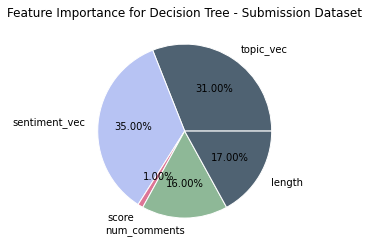

In [0]:
dtModel= pipeline_rf7.fit(train_data2)
va = dtModel.stages[-2]
tree = dtModel.stages[-1]
importance= list(zip(va.getInputCols(), tree.featureImportances))
importance_df= pd.DataFrame(importance)
importance_df.columns=['factor','importance_score']

# Create a set of colors
import matplotlib.pyplot as plt
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']
importance_df= importance_df.loc[importance_df['importance_score']!=0,:]
# Use it thanks to the color argument
plt.pie(importance_df['importance_score'], autopct='%.2f%%',labels=importance_df['factor'], labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors)

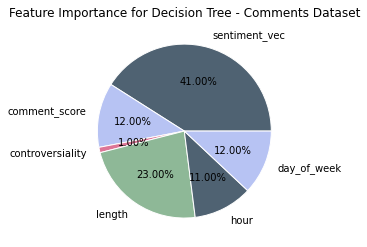

In [0]:
dtModel= pipeline_rf7.fit(train_data)
va = dtModel.stages[-2]
tree = dtModel.stages[-1]
importance= list(zip(va.getInputCols(), tree.featureImportances))
importance_df= pd.DataFrame(importance)
importance_df.columns=['factor','importance_score']

# Create a set of colors
import matplotlib.pyplot as plt
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']
importance_df= importance_df.loc[importance_df['importance_score']!=0,:]
# Use it thanks to the color argument
plt.pie(importance_df['importance_score'], autopct='%.2f%%',labels=importance_df['factor'], labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors)